In [15]:
import re
import nltk as nltk
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import plotly
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.graph_objs as go
import plotly.figure_factory as ff
import PIL
from PIL import Image
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
from wordcloud import WordCloud,STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from nltk.sentiment import vader
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import word_tokenize
from scipy import stats
from heapq import nlargest
sns.set_style('darkgrid')

In [2]:
pwd = os.getcwd()

In [3]:
rally_df = pd.read_csv("Datasets/trump_rally.csv",keep_default_na=False, na_values=[""])
rally_df.head(5) 

Date  Day Month  Year          City           State  \
0  19-Dec-19   19   Dec  2019  Battle Creek        Michigan   
1  10-Sep-20   10   Sep  2020      Freeland        Michigan   
2  18-Sep-20   18   Sep  2020       Bemidji       Minnesota   
3  10-Oct-19   10   Oct  2019   Minneapolis       Minnesota   
4  28-Feb-20   28   Feb  2020    Charleston  South Carolina   

   State millenials population percentage (25 - 34)  \
0                                              13.0   
1                                              13.0   
2                                              13.6   
3                                              13.6   
4                                              13.0   

   State late adult population percentage (55-64)  \
0                                            14.0   
1                                            14.0   
2                                            13.4   
3                                            13.4   
4                                            13.5   

   State adult Tertiary Education Rate (25+ years old)   \
0                                               32.2      
1                                               32.2      
2                                               31.9      
3                                               31.9      
4                                               30.2      

   State unemployment Rate (16+ years old)  ...  \
0                                      5.0  ...   
1                                      5.0  ...   
2                                      3.2  ...   
3                                      3.2  ...   
4                                      4.7  ...   

   Numbers of Geo Location Mentioned  Numbers of Monetary Keywords Mentioned  \
0                                113                                      10   
1                                131                                       5   
2                                160                                       6   
3                                 94                                       4   
4                                 72                                       3   

   Numbers of Peoples' Name Mentioned  Positive Sentiment  Neutral Sentiment  \
0                                  38               0.303              0.537   
1                                  65               0.315              0.530   
2                                  86               0.321              0.535   
3                                  68               0.335              0.506   
4                                  57               0.336              0.511   

   Negative Sentiment  Achievements  Plans, Vision and Appealing Support  \
0               0.159        12.345                                4.601   
1               0.155         2.950                                0.764   
2               0.144        10.313                                0.000   
3               0.159         5.748                                3.958   
4               0.153         3.493                                5.185   

   Political Adversaries  Dominant Topic  
0                  0.000     Achievement  
1                  6.017     Adversaries  
2                  4.673     Achievement  
3                  1.229     Achievement  
4                  0.002           Plans  

[5 rows x 42 columns]

In [4]:
corpus = []          
for dirname, _, filenames in os.walk("Trump_Rally_Speech_Text_Corpora/"):
    for filename in filenames:
        with open((os.path.join(dirname, filename)), encoding="UTF-8") as file_input: corpus.append(file_input.read(),)

In [5]:
place_name = [i.replace(".txt"," ") for i in filenames]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
place, month_list, date = [],[],[]
for name in place_name:
    index= -1
    for month in months:
        index =name.find(month)
        if index != -1:
            month_list.append(month)
            break
    place.append(name[:index])
    date.append(name[index+3:])

In [6]:
trump_df = pd.DataFrame({"Month":month_list,"Year":date,"City":place, "Speech":corpus})
trump_df[['Day','Year']] = trump_df.Year.str.split("_",expand=True,)

In [7]:
trump_df["City"] = trump_df["City"].str.replace( r"([A-Z])", r" \1").str.strip()
trump_df["City"] = trump_df["City"].replace("Winston- Salem", "Winston-Salem")
trump_df.head(5)

C:\Users\Addi\AppData\Local\Temp/ipykernel_10664/915753475.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



Month   Year          City  \
0   Dec  2019   Battle Creek   
1   Sep  2020        Bemidji   
2   Feb  2020     Charleston   
3   Mar  2020      Charlotte   
4   Aug  2019     Cincinnati   

                                              Speech Day  
0  Thank you. Thank you. Thank you to Vice Presid...  19  
1  There's a lot of people. That's great. Thank y...  18  
2  Thank you. Thank you. Thank you. All I can say...  28  
3  I want to thank you very much. North Carolina,...   2  
4  Thank you all. Thank you very much. Thank you ...   1

In [8]:
rally_df = pd.merge(left=rally_df, right=trump_df, left_on="City", right_on="City", how="left")
rally_df = rally_df.drop(["Month_y", "Year_y", "Day_y"], axis = 1)
trump_df = trump_df.rename(columns={"Day_x":"Day","Month_x":"Year_x","Speech_x":"Speech"})
rally_df.head(5)

Date  Day_x Month_x  Year_x          City           State  \
0  19-Dec-19     19     Dec    2019  Battle Creek        Michigan   
1  10-Sep-20     10     Sep    2020      Freeland        Michigan   
2  18-Sep-20     18     Sep    2020       Bemidji       Minnesota   
3  10-Oct-19     10     Oct    2019   Minneapolis       Minnesota   
4  28-Feb-20     28     Feb    2020    Charleston  South Carolina   

   State millenials population percentage (25 - 34)  \
0                                              13.0   
1                                              13.0   
2                                              13.6   
3                                              13.6   
4                                              13.0   

   State late adult population percentage (55-64)  \
0                                            14.0   
1                                            14.0   
2                                            13.4   
3                                            13.4   
4                                            13.5   

   State adult Tertiary Education Rate (25+ years old)   \
0                                               32.2      
1                                               32.2      
2                                               31.9      
3                                               31.9      
4                                               30.2      

   State unemployment Rate (16+ years old)  ...  \
0                                      5.0  ...   
1                                      5.0  ...   
2                                      3.2  ...   
3                                      3.2  ...   
4                                      4.7  ...   

   Numbers of Monetary Keywords Mentioned  Numbers of Peoples' Name Mentioned  \
0                                      10                                  38   
1                                       5                                  65   
2                                       6                                  86   
3                                       4                                  68   
4                                       3                                  57   

   Positive Sentiment  Neutral Sentiment  Negative Sentiment  Achievements  \
0               0.303              0.537               0.159        12.345   
1               0.315              0.530               0.155         2.950   
2               0.321              0.535               0.144        10.313   
3               0.335              0.506               0.159         5.748   
4               0.336              0.511               0.153         3.493   

   Plans, Vision and Appealing Support  Political Adversaries  Dominant Topic  \
0                                4.601                  0.000     Achievement   
1                                0.764                  6.017     Adversaries   
2                                0.000                  4.673     Achievement   
3                                3.958                  1.229     Achievement   
4                                5.185                  0.002           Plans   

                                              Speech  
0  Thank you. Thank you. Thank you to Vice Presid...  
1  We brought you a lot of car plants, Michigan. ...  
2  There's a lot of people. That's great. Thank y...  
3  Thank you very much. Thank you, Minnesota. Thi...  
4  Thank you. Thank you. Thank you. All I can say...  

[5 rows x 43 columns]

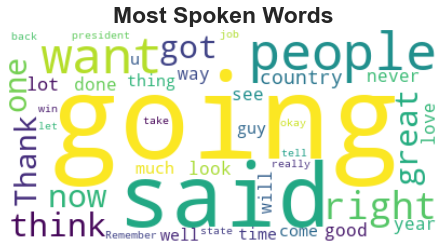

In [9]:
stopwords_plus = set(STOPWORDS)
stopwords_plus.update(["say", "go", "know", "don"])
most_words_global = " ".join(tmpwords for tmpwords in trump_df.Speech)

wordcloud = WordCloud(max_words=40, stopwords=stopwords_plus, background_color="white").generate(most_words_global)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most Spoken Words',fontsize=23,fontweight='bold')
plt.show()

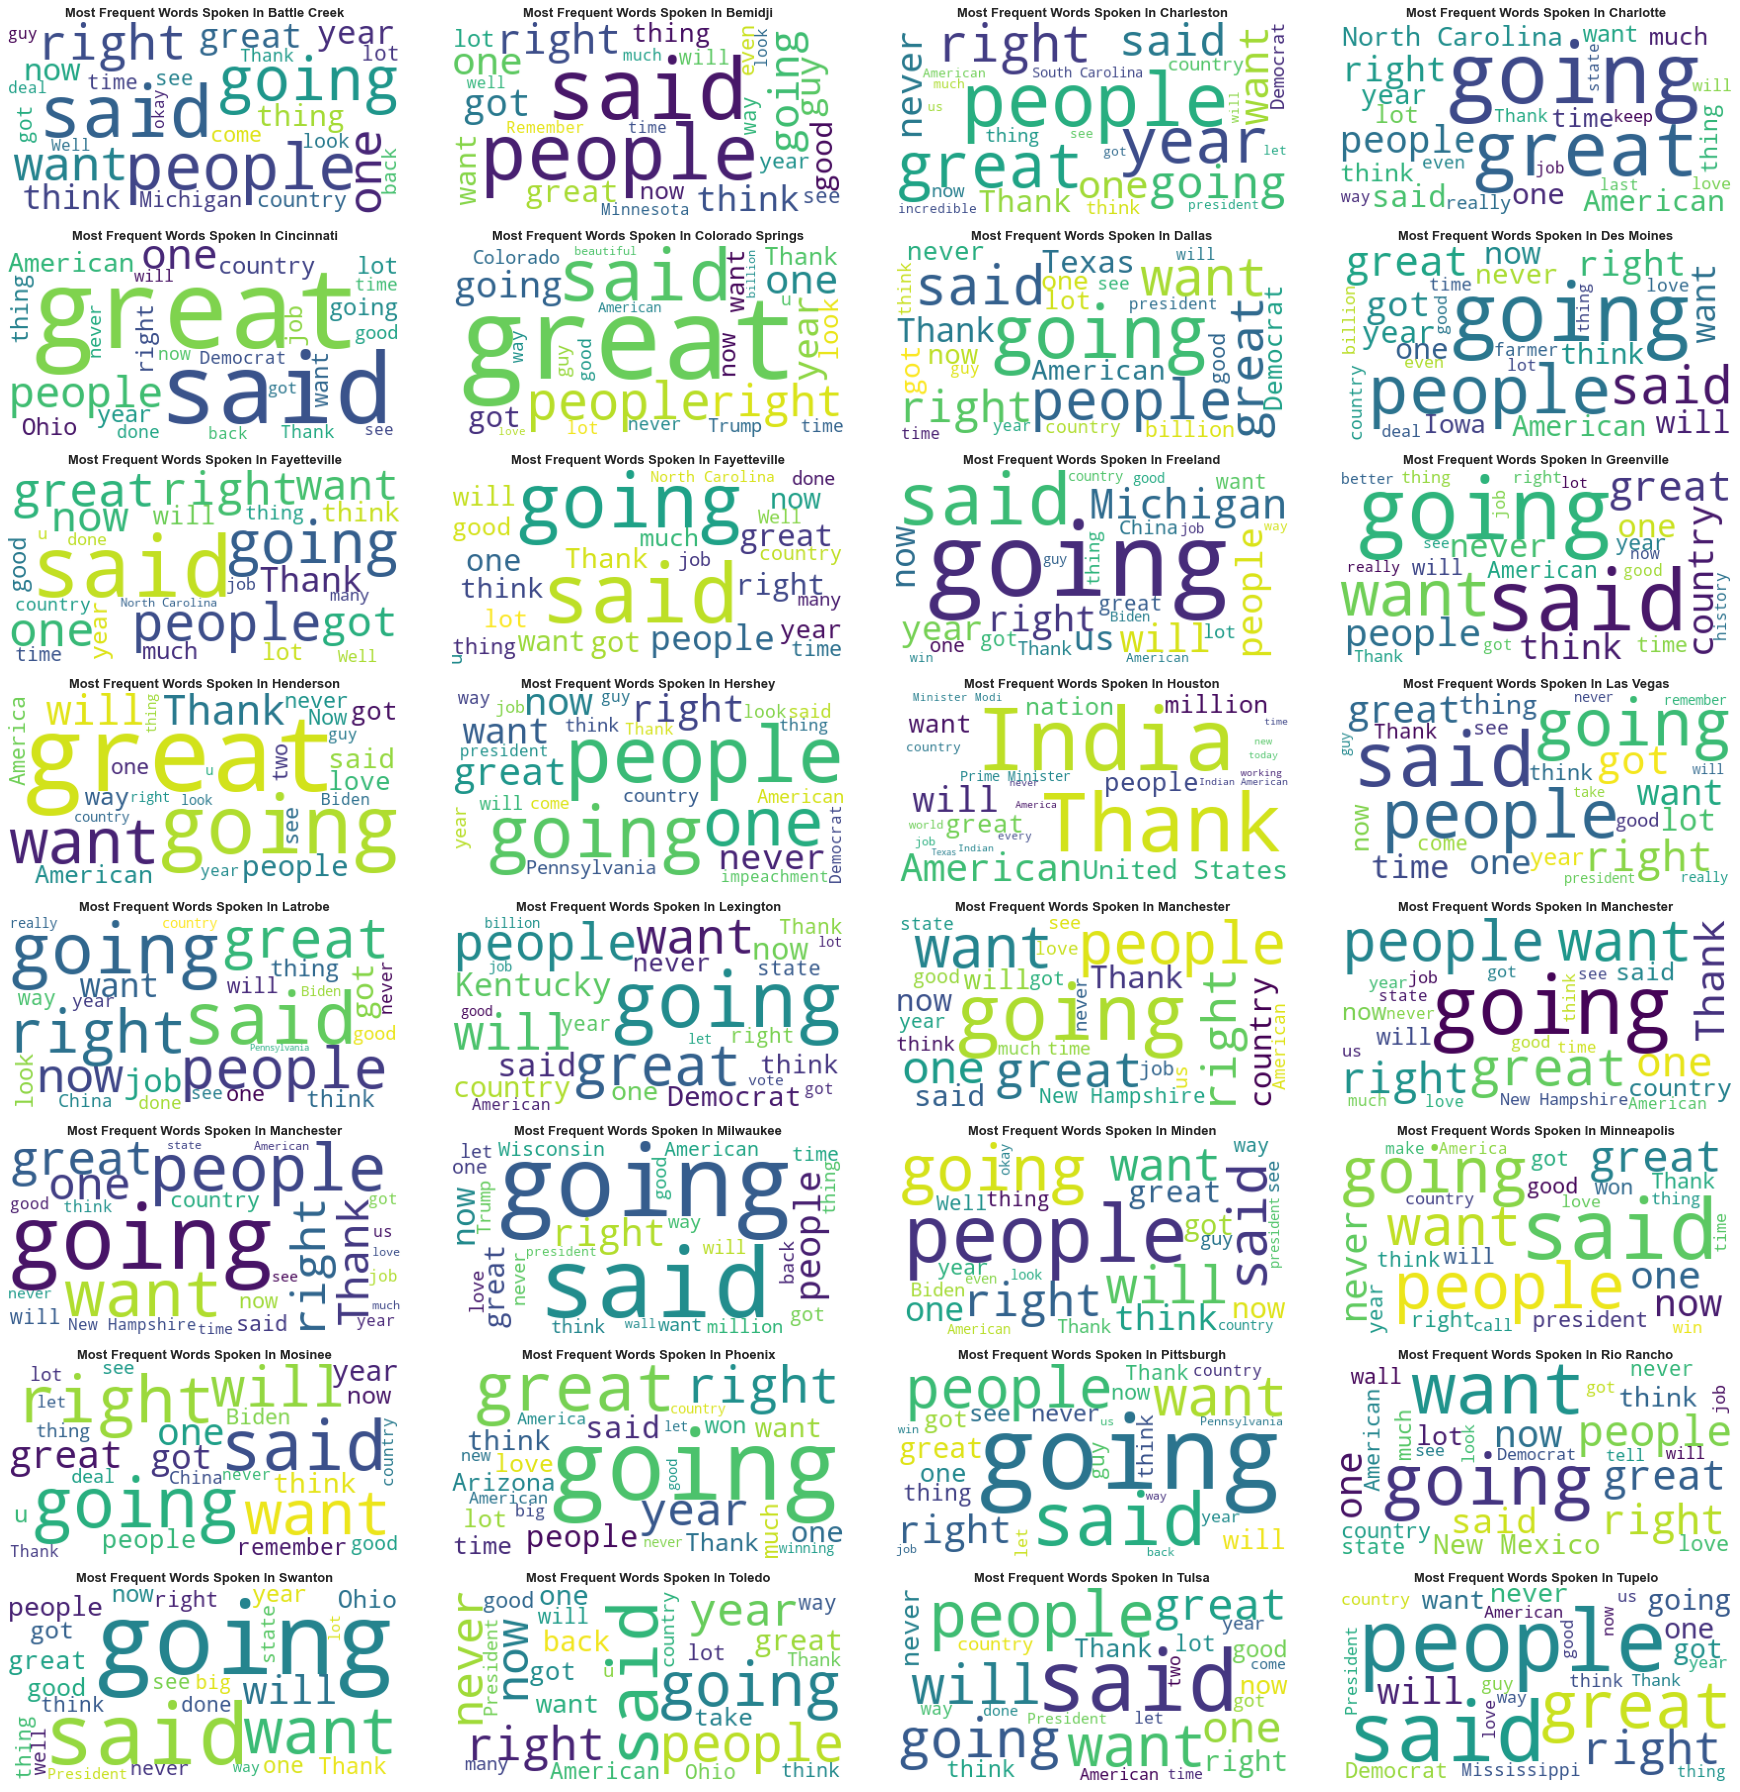

In [10]:
fig,axes = plt.subplots(8,4)
fig.set_figwidth(25)
fig.set_figheight(25)
r,c=0,0
for cit in trump_df.City:
    text = trump_df.query('City == "{}"'.format(cit))
    text = ' '.join(text.Speech.values)
    axes[r][c].imshow(WordCloud(max_words=25, stopwords=stopwords_plus, background_color="white").generate(text))
    axes[r][c].axis('off')
    axes[r][c].set_title('Most Frequent Words Spoken In {}'.format(cit),fontsize=13,fontweight='bold')
    c+=1
    if c == 4:
        c = 0
        r+=1
    if r == 8:
        break
plt.tight_layout()

In [16]:
pos_word_list = []
text1 = ' '.join(trump_df.Speech.values)
tokenized_sentence = text1.split(' ')
tokenized_sentence = [w for w in tokenized_sentence if w not in list(stopwords_plus)]
for word1 in tokenized_sentence:
    if (sid.polarity_scores(word1)['compound']) >= 0.1:
        pos_word_list.append(word1)
pos_word_list
pos_word_dict = {word1:len(re.findall(word1,text1)) for word1 in pos_word_list}
top_10_pos = nlargest(10, pos_word_dict, key=pos_word_dict.get) 

TypeError: polarity_scores() missing 1 required positional argument: 'text'

In [ ]:
neg_word_list = []
text2 = ' '.join(trump_df.Speech.values)
tokenized_sentence = text.split(' ')
tokenized_sentence = [w for w in tokenized_sentence if w not in list(stopwords_plus)]
for word2 in tokenized_sentence:
    if (sid.polarity_scores(word2)['compound']) <= -0.1:
        neg_word_list.append(word2)
neg_word_dict = {word2:len(re.findall(word2,text2)) for word2 in neg_word_list}       

top_10_neg = nlargest(10, neg_word_dict, key=neg_word_dict.get)

In [ ]:
plt.figure(figsize=(20,15), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 800,background_color='white').generate(' '.join(nlargest(30, pos_word_dict, key=pos_word_dict.get))))
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Top 30 Positive Words',fontsize=23,fontweight='bold')
plt.show()

In [ ]:
plt.figure(figsize=(20,15), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 800,background_color='white').generate(' '.join(nlargest(30, neg_word_dict, key=neg_word_dict.get))))
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Top 30 Negative Words',fontsize=23,fontweight='bold')
plt.show()